In [12]:
# Import libraries
import scipy.io
import json
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt

In [2]:
file = pathlib.Path("10_60_min_comparison.mat")
mat = scipy.io.loadmat(file)

<img src="./img/1.png" alt="1" width="300"/>

In [3]:
print(f".mat titles cnt: {len(mat.keys())}")
print(f"segmented frames cnt: {mat['Tracked_60min'].shape[1]}")
all_frames = mat["Tracked_60min"][0]

.mat titles cnt: 24
segmented frames cnt: 101


In [4]:
print(all_frames)

[array([[(array(['E:\\Hong\\12.31.22_Lifetime_FISH\\ZprojectWithDAPI\\60min_H\\'],
               dtype='<U56'), array([[array(['MAX_H_w3-555 Exon_s001.tif'], dtype='<U26')]],
               dtype=object), array([[array([[(array([[0, 0, 0, ..., 0, 0, 0],
                                [0, 0, 0, ..., 0, 0, 0],
                                [0, 0, 0, ..., 0, 0, 0],
                                ...,
                                [0, 0, 0, ..., 0, 0, 0],
                                [0, 0, 0, ..., 0, 0, 0],
                                [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[1407,   48]], dtype=uint16), array([[112, 122]], dtype=uint8), array([], shape=(0, 0), dtype=uint8), array([], shape=(0, 0), dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
                                [0, 0, 0, ..., 0, 0, 0],
                                [0, 0, 0, ..., 0, 0, 0],
                                ...,
                                [0, 0, 0, ..., 0, 0, 0],
                     

In [5]:
def convert(all_frames):
    converted: list[dict()] = []
    for i in range(all_frames.shape[0]):
        cur = dict()
        # use try catch to avoid error on edge cases
        try:
            for j in range(100):
                cur[j] = all_frames[i][0,0][j][0]
        except IndexError:
            pass
        converted.append(cur)
    return converted

<img src="./img/2.png" alt="1" width="500"/>

In [6]:
def getCells(singleFrame, cellsLoc=2, cellsInfoIndex=12):
    ttlCellsInFrame = singleFrame[cellsLoc].shape[0]
    cells = []
    for i in range(ttlCellsInFrame):
        info = []
        cell = singleFrame[cellsLoc][i][0,0]
        for j in range(cellsInfoIndex):
            info.append(cell[j])
        cells.append(info)
    return cells

In [7]:
all_frames_converted = convert(all_frames)
frame_no_1 = all_frames_converted[0]

<img src="./img/3.png" alt="1" width="300"/>

In [8]:
all_cells_in_frame_no_1 = getCells(frame_no_1)
print(f"mask: \n{all_cells_in_frame_no_1[0][0]}")
print(f"mask shape: {all_cells_in_frame_no_1[0][0].shape}")

mask: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
mask shape: (112, 122)


bondary_matrix_first_col: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


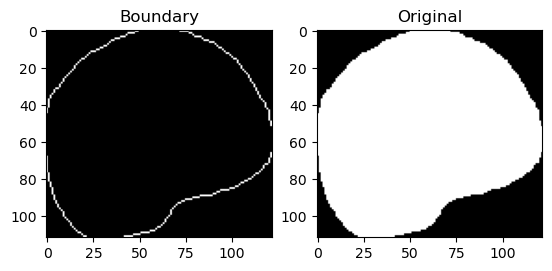

In [25]:
np.set_printoptions(threshold = np.inf)
bondary = plt.subplot(1, 2, 1)
bondary_matrix = scipy.ndimage.binary_dilation(all_cells_in_frame_no_1[0][0]) - all_cells_in_frame_no_1[0][0]
print(f"bondary_matrix_first_col: \n{bondary_matrix[:, 0]}")
bondary.imshow(bondary_matrix, cmap='gray')
bondary.set_title('Boundary')
original = plt.subplot(1, 2, 2)
original.imshow(all_cells_in_frame_no_1[0][0], cmap='gray')
original.set_title('Original')
plt.show()